# Resistance plant gene prediction - Modeling
---

## Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Data preparation and scaling
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# Modeling Baseline
from sklearn.linear_model import LogisticRegression

# Modeling library
import tensorflow as tf
from tensorflow.keras.models import Model

# Modeling Layers
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Conv1D, Reshape, MaxPooling1D

# Speed up the model's training
from tensorflow.keras import mixed_precision


# Helper functions
import helper_functions as hf
from Positional_encoding import PositionalEncoding

2024-07-03 22:00:37.400551: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 22:00:37.421263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 22:00:37.421275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 22:00:37.421972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 22:00:37.425986: I tensorflow/core/platform/cpu_feature_guar

## Data loading

In [2]:
proteins = pd.read_csv('Data/train.csv')

In [3]:
proteins.head()

,ID,Sequence,Label
0,0,MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...,0
1,4,MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...,0
2,5,MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...,0
3,6,MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...,0
4,7,MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...,0


In [4]:
proteins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14161 entries, 0 to 14160
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        14161 non-null  int64 
 1   Sequence  14161 non-null  object
 2   Label     14161 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 332.0+ KB


In [5]:
proteins[proteins.duplicated()].shape

(0, 3)

In [6]:
proteins = proteins[proteins['Sequence'].str.len() < 1000].reset_index(drop=True)

In [7]:
labels = pd.DataFrame(proteins['Label'])
labels.head()

,Label
0,0
1,0
2,0
3,0
4,0


In [8]:
sequences = proteins['Sequence']
sequences.head()

0    MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...
1    MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...
2    MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...
3    MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...
4    MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...
Name: Sequence, dtype: object

In [9]:
sequences.shape

(13507,)

## Data Preparation

### Extract Aminos Frequency

In [10]:
aminos = hf.amino_count(sequences)
aminos

,M,D,S,R,Q,Y,E,V,I,G,...,N,H,K,T,C,P,W,X,Z,B
0,22,53,123,48,35,16,66,56,55,35,...,42,23,75,39,21,68,4,0,0,0
1,3,2,11,6,2,3,15,7,9,11,...,3,2,30,7,0,9,0,0,0,0
2,2,2,7,5,3,1,3,7,3,5,...,6,3,5,3,1,4,1,0,0,0
3,10,9,27,6,13,15,12,31,19,22,...,13,5,22,24,10,15,5,0,0,0
4,9,21,28,20,9,8,19,27,19,43,...,11,10,17,10,6,11,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13502,4,4,7,2,2,3,12,5,2,5,...,3,1,11,5,0,3,2,0,0,0
13503,10,23,42,30,7,13,21,26,6,36,...,5,7,12,19,10,34,6,0,0,0
13504,4,21,26,19,12,11,23,14,8,26,...,19,16,21,14,11,16,4,0,0,0
13505,16,32,45,38,16,14,23,51,23,46,...,12,8,15,22,6,25,8,0,0,0


### Tokenization

#### Single Amino Acid

* Tokenize the sequences on char level

In [11]:
# Tokenize on char level
tokenizer1 = Tokenizer(char_level=True)
tokenizer1.fit_on_texts(sequences)
sequences_1p = tokenizer1.texts_to_sequences(sequences)

# Padd the sequences to match all the length of the biggest
sequences_1p = pad_sequences(sequences_1p, padding='post')

In [12]:
sequences_1p

array([[17,  9,  2, ...,  0,  0,  0],
       [17,  3, 12, ...,  0,  0,  0],
       [17,  1,  6, ...,  0,  0,  0],
       ...,
       [17, 16, 14, ...,  0,  0,  0],
       [17,  3,  3, ...,  0,  0,  0],
       [17,  4, 10, ...,  0,  0,  0]], dtype=int32)

* Max sequence length

In [13]:
len(sequences_1p[0])

997

* Append the frequence of each amino in sequence df

In [14]:
amino_counts = hf.amino_count(sequences_1p)
amino_counts

,17,9,2,8,15,16,6,5,10,4,...,18,7,11,19,12,20,0,21,22,23
0,22,53,123,48,35,16,66,56,55,35,...,23,75,39,21,68,4,54,0,0,0
1,3,2,11,6,2,3,15,7,9,11,...,2,30,7,0,9,0,847,0,0,0
2,2,2,7,5,3,1,3,7,3,5,...,3,5,3,1,4,1,916,0,0,0
3,10,9,27,6,13,15,12,31,19,22,...,5,22,24,10,15,5,653,0,0,0
4,9,21,28,20,9,8,19,27,19,43,...,10,17,10,6,11,5,643,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13502,4,4,7,2,2,3,12,5,2,5,...,1,11,5,0,3,2,905,0,0,0
13503,10,23,42,30,7,13,21,26,6,36,...,7,12,19,10,34,6,611,0,0,0
13504,4,21,26,19,12,11,23,14,8,26,...,16,21,14,11,16,4,695,0,0,0
13505,16,32,45,38,16,14,23,51,23,46,...,8,15,22,6,25,8,473,0,0,0


In [15]:
len(sequences_1p), len(amino_counts)

(13507, 13507)

In [16]:
sequences_1p = pd.DataFrame(sequences_1p)
sequences_1p.head()

,0,1,2,3,4,5,6,7,8,9,...,987,988,989,990,991,992,993,994,995,996
0,17,9,2,8,17,9,15,16,6,5,...,0,0,0,0,0,0,0,0,0,0
1,17,3,12,7,3,6,7,7,12,3,...,0,0,0,0,0,0,0,0,0,0
2,17,1,6,1,18,13,6,13,10,9,...,0,0,0,0,0,0,0,0,0,0
3,17,3,6,12,6,1,5,14,4,4,...,0,0,0,0,0,0,0,0,0,0
4,17,11,2,19,4,19,1,5,1,6,...,0,0,0,0,0,0,0,0,0,0


In [17]:
sequences_1p = pd.concat([sequences_1p, amino_counts], axis=1)
sequences_1p

,0,1,2,3,4,5,6,7,8,9,...,18,7,11,19,12,20,0,21,22,23
0,17,9,2,8,17,9,15,16,6,5,...,23,75,39,21,68,4,54,0,0,0
1,17,3,12,7,3,6,7,7,12,3,...,2,30,7,0,9,0,847,0,0,0
2,17,1,6,1,18,13,6,13,10,9,...,3,5,3,1,4,1,916,0,0,0
3,17,3,6,12,6,1,5,14,4,4,...,5,22,24,10,15,5,653,0,0,0
4,17,11,2,19,4,19,1,5,1,6,...,10,17,10,6,11,5,643,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13502,17,4,1,7,6,6,13,6,6,18,...,1,11,5,0,3,2,905,0,0,0
13503,17,17,17,17,4,6,4,5,2,2,...,7,12,19,10,34,6,611,0,0,0
13504,17,16,14,14,14,15,16,2,13,2,...,16,21,14,11,16,4,695,0,0,0
13505,17,3,3,8,19,2,10,3,13,17,...,8,15,22,6,25,8,473,0,0,0


#### Di-peptide

* Split the sequences per 2 aminos

In [18]:
dipeptide_sequences = hf.split_sequences(sequences, step=2)
pd.DataFrame(dipeptide_sequences[212])

,0
0,MD
1,LI
2,AG
3,ES
4,SK
...,...
473,VF
474,GI
475,WR
476,YS


In [19]:
sequences[212]

'MDLIAGESSKVLRKQGFRSLKLMSVDMEQELGNELEPFGADYGRLDNGLIYYVRRNSKPRMRAALALAVKVGSVLEEEDQRGVAHIVEHLAFSATTRYTNHDIVKFLESIGAEFGPCQNAMTTADETIYELFVPVDKPELLSQAISILAEFSSEIRVSKEDLEKERGAVMEEYRGNRNATGRMQDSHWQLMMEGSKYAERLPIGLEKVIRSVPAATVKQFYQKWYHLCNMAVVAVGDFPDTKTVVDLIKTHFEDKRSSSEPPQIPVFPVPSHEETRFSCFVESEAAGSAVMISYKMPVSDLKTVKDYRDMLAESMFLHALNQRLFKISRRKDPPFFACSVAADVLVARVRLHGFSEREISVVRALMMSEIESAYLERDQVQSTSLRDEYIQHFLHKEPVIGIEYEAQLQKTLLPQISASDVSRYSEKLRTSCGCVIKSMEPKSAATIDHMRNVVSKVNSLEEEKMIAPWDEENIPEEIVSEKPTPGDITHQLEYPEVGVTELTLSNGMQVCYKSTDFLDDQVLFTGFSYGGLSELPESDYISCSMGSTIAGEIGMFGYKPSVLMDMLADLETALQLVYQLFTTNVMPQEEEVGIVMQMAEESVRARERDPYTVFANRVKELNYGNSYFFRPIRISELRKVDPLKACEYFNSCFRDPSTFTVVIVGNLDPTIALPLILQYLGGIPKPPQPVLNFNRDDLKGLPFTFPTKITKEFVRSPMVEAQCSVQLCFPVQLTNGTMIEEIHCIGFLGKLLETKIIQFLRFEHGQIYSAEVSVFLGGNKPSRTADLRGDISVNFSCDPEISSKLVDLALEEIVRLQKEGPSQEDISAILEIEQRAHENGMQENYYWLDRIIRGYQSRVYAGDLGASCKILEEGRLRMRESLAPQTAQAALQRILPHPCKKQYTAVILMPQRSRFGFLSSIFSSRSEGPYIRDTKILAGIAGLGVVVFGIWRYSRK'

In [20]:
len(dipeptide_sequences[212]), len(sequences[212])

(478, 956)

In [21]:
tokenizer2 = Tokenizer(char_level=False)
tokenizer2.fit_on_texts(dipeptide_sequences)
sequences_2p = tokenizer2.texts_to_sequences(dipeptide_sequences)
sequences_2p = pad_sequences(sequences_2p, padding='post')

In [22]:
sequences_2p

array([[256,  57, 256, ...,   0,   0,   0],
       [126, 149,  56, ...,   0,   0,   0],
       [195,  20, 322, ...,   0,   0,   0],
       ...,
       [367, 179, 254, ...,   0,   0,   0],
       [126,  89, 253, ...,   0,   0,   0],
       [227, 321,  75, ...,   0,   0,   0]], dtype=int32)

* Max length

In [23]:
len(sequences_2p[0])

499

* Append the frequence of each amino in sequence_2p df

In [24]:
amino_counts = hf.amino_count(sequences_2p)
amino_counts

,256,57,339,68,188,228,84,50,123,3,...,457,458,459,460,461,462,463,464,465,466
0,2,7,1,2,2,1,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
4,0,3,0,1,0,0,4,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13503,0,1,0,0,0,0,1,1,0,5,...,0,0,0,0,0,0,0,0,0,0
13504,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
13505,1,2,1,0,0,0,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
len(sequences_2p), len(amino_counts)

(13507, 13507)

In [26]:
sequences_2p = pd.DataFrame(sequences_2p)
sequences_2p.head()

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
0,256,57,256,339,68,188,228,84,50,123,...,0,0,0,0,0,0,0,0,0,0
1,126,149,56,36,104,38,135,56,38,35,...,0,0,0,0,0,0,0,0,0,0
2,195,20,322,171,132,101,240,276,252,130,...,0,0,0,0,0,0,0,0,0,0
3,126,200,20,159,6,66,144,19,343,39,...,0,0,0,0,0,0,0,0,0,0
4,295,258,282,10,16,88,72,237,76,3,...,0,0,0,0,0,0,0,0,0,0


In [27]:
sequences_2p = pd.concat([sequences_2p, amino_counts], axis=1)
sequences_2p

,0,1,2,3,4,5,6,7,8,9,...,457,458,459,460,461,462,463,464,465,466
0,256,57,256,339,68,188,228,84,50,123,...,0,0,0,0,0,0,0,0,0,0
1,126,149,56,36,104,38,135,56,38,35,...,0,0,0,0,0,0,0,0,0,0
2,195,20,322,171,132,101,240,276,252,130,...,0,0,0,0,0,0,0,0,0,0
3,126,200,20,159,6,66,144,19,343,39,...,0,0,0,0,0,0,0,0,0,0
4,295,258,282,10,16,88,72,237,76,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13502,227,18,9,184,296,56,88,220,44,20,...,0,0,0,0,0,0,0,0,0,0
13503,347,347,76,39,1,115,375,231,31,22,...,0,0,0,0,0,0,0,0,0,0
13504,367,179,254,192,75,82,72,27,11,4,...,0,0,0,0,0,0,0,0,0,0
13505,126,89,253,93,341,318,13,244,27,21,...,0,0,0,0,0,0,0,0,0,0


* Also append per char level the frequence

In [28]:
aminos

,M,D,S,R,Q,Y,E,V,I,G,...,N,H,K,T,C,P,W,X,Z,B
0,22,53,123,48,35,16,66,56,55,35,...,42,23,75,39,21,68,4,0,0,0
1,3,2,11,6,2,3,15,7,9,11,...,3,2,30,7,0,9,0,0,0,0
2,2,2,7,5,3,1,3,7,3,5,...,6,3,5,3,1,4,1,0,0,0
3,10,9,27,6,13,15,12,31,19,22,...,13,5,22,24,10,15,5,0,0,0
4,9,21,28,20,9,8,19,27,19,43,...,11,10,17,10,6,11,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13502,4,4,7,2,2,3,12,5,2,5,...,3,1,11,5,0,3,2,0,0,0
13503,10,23,42,30,7,13,21,26,6,36,...,5,7,12,19,10,34,6,0,0,0
13504,4,21,26,19,12,11,23,14,8,26,...,19,16,21,14,11,16,4,0,0,0
13505,16,32,45,38,16,14,23,51,23,46,...,12,8,15,22,6,25,8,0,0,0


In [29]:
sequences_2p = pd.concat([sequences_2p, aminos], axis=1)
sequences_2p

,0,1,2,3,4,5,6,7,8,9,...,N,H,K,T,C,P,W,X,Z,B
0,256,57,256,339,68,188,228,84,50,123,...,42,23,75,39,21,68,4,0,0,0
1,126,149,56,36,104,38,135,56,38,35,...,3,2,30,7,0,9,0,0,0,0
2,195,20,322,171,132,101,240,276,252,130,...,6,3,5,3,1,4,1,0,0,0
3,126,200,20,159,6,66,144,19,343,39,...,13,5,22,24,10,15,5,0,0,0
4,295,258,282,10,16,88,72,237,76,3,...,11,10,17,10,6,11,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13502,227,18,9,184,296,56,88,220,44,20,...,3,1,11,5,0,3,2,0,0,0
13503,347,347,76,39,1,115,375,231,31,22,...,5,7,12,19,10,34,6,0,0,0
13504,367,179,254,192,75,82,72,27,11,4,...,19,16,21,14,11,16,4,0,0,0
13505,126,89,253,93,341,318,13,244,27,21,...,12,8,15,22,6,25,8,0,0,0


#### Tri-peptide

* Split the sequences per 3 aminos

In [30]:
tripeptide_sequences = hf.split_sequences(sequences, step=3)
pd.DataFrame(tripeptide_sequences[500])

,0
0,MDA
1,NFE
2,MPP
3,VGG
4,MND
...,...
179,AKF
180,YGN
181,MFA
182,KLS


In [31]:
sequences[500]

'MDANFEMPPVGGMNDDDDMDFGDGASFLKVGEEKEIQQGLKKKLLKEGEGYETPENGDEVEVHYTGTLLDGTKFDSSRDRATPFKFTLGQGQVIKGWDIGIKTMKKGENAVFTIPAELAYGESGSPPTIPANATLQFDVELLKWDSVKDICKDGGVFKKILAVGEKWENPKDLDEVLVKFEAKLEDGTVVGKSDGVEFTVKDGHFCPALTKAVKTMKKGEKVLLTVKPQYGFGEKGKPASAGEGAVPPNATLEINLELVSWKTVSEVTDDNKVVKKVLKEGDGYERPNEGAVVKVKLIGKLQDGTVFLKKGHGENEEPFEFKTDEEQVVDGLDRAVMKMKKGEVALVTIDPEYAFGSNESQQELAVVPPNSTVTYEVDLLTFDKERESWDMNTEEKIEAASKKKEEGNSKFKGGKYSLASKRYEKAVKFIEYDTSFSEEEKKQAKALKVACNLNDAACKLKLKDYKQAEKLCTKVLELESTNVKALYRRAQAYMELSDLDLAEFDVKKALEIDPNNREVKLEQKRLKEKMKEFNKKEAKFYGNMFAKLSKE'

In [32]:
tokenizer3 = Tokenizer(char_level=False)
tokenizer3.fit_on_texts(tripeptide_sequences)
sequences_3p = tokenizer3.texts_to_sequences(tripeptide_sequences)
sequences_3p = pad_sequences(sequences_3p, padding='post')

In [33]:
sequences_3p

array([[2109, 5723, 5998, ...,    0,    0,    0],
       [1845,  749, 1140, ...,    0,    0,    0],
       [2045, 3704, 2843, ...,    0,    0,    0],
       ...,
       [6676, 5322, 2979, ...,    0,    0,    0],
       [ 174, 4038, 2436, ...,    0,    0,    0],
       [3427, 4256, 1161, ...,    0,    0,    0]], dtype=int32)

* Max length

In [34]:
len(sequences_3p[0])

333

In [35]:
sequences_3p = pd.DataFrame(sequences_3p)
sequences_3p

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,332
0,2109,5723,5998,2661,3333,1658,1191,370,4953,1618,...,0,0,0,0,0,0,0,0,0,0
1,1845,749,1140,383,1713,248,632,2572,55,1140,...,0,0,0,0,0,0,0,0,0,0
2,2045,3704,2843,1390,4407,6061,1248,2136,231,218,...,0,0,0,0,0,0,0,0,0,0
3,1037,606,1057,1051,2177,4955,1554,181,4627,239,...,0,0,0,0,0,0,0,0,0,0
4,3191,5945,50,542,4565,366,55,772,320,2473,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13502,1491,167,1255,5087,2873,718,814,2168,85,3080,...,0,0,0,0,0,0,0,0,0,0
13503,5004,3739,306,611,6279,2853,194,703,138,3,...,0,0,0,0,0,0,0,0,0,0
13504,6676,5322,2979,471,966,141,107,1098,5664,3336,...,0,0,0,0,0,0,0,0,0,0
13505,174,4038,2436,6985,4164,131,182,135,2435,972,...,0,0,0,0,0,0,0,0,0,0


### Train Test Split

#### Single Amino Acid

In [36]:
sequences_1p_train, sequences_1p_test, labels_1p_train, labels_1p_test = train_test_split(sequences_1p, labels, test_size=0.2, random_state=33)

In [37]:
print('Training shapes: ', sequences_1p_train.shape, labels_1p_train.shape)
print('Test shapes: ', sequences_1p_test.shape, labels_1p_test.shape)

Training shapes:  (10805, 1021) (10805, 1)
Test shapes:  (2702, 1021) (2702, 1)


In [38]:
# pd.DataFrame(sequences_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/train.csv')
# pd.DataFrame(sequences_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/test.csv')

# pd.DataFrame(labels_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_test.csv')

#### Di-peptide

In [39]:
sequences_2p.columns = sequences_2p.columns.astype(str)

In [40]:
sequences_2p_train, sequences_2p_test, labels_2p_train, labels_2p_test = train_test_split(sequences_2p, labels, test_size=0.2, random_state=33)

In [41]:
print('Training shapes: ', sequences_2p_train.shape, labels_2p_train.shape)
print('Test shapes: ', sequences_2p_test.shape, labels_2p_test.shape)

Training shapes:  (10805, 989) (10805, 1)
Test shapes:  (2702, 989) (2702, 1)


In [42]:
# pd.DataFrame(sequences_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/train.csv')
# pd.DataFrame(sequences_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/test.csv')

# pd.DataFrame(labels_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_test.csv')

#### Tri-peptide

In [43]:
sequences_3p_train, sequences_3p_test, labels_3p_train, labels_3p_test = train_test_split(sequences_3p, labels, test_size=0.2, random_state=33)

In [44]:
print('Training shapes: ', sequences_3p_train.shape, labels_3p_train.shape)
print('Test shapes: ', sequences_3p_test.shape, labels_3p_test.shape)

Training shapes:  (10805, 333) (10805, 1)
Test shapes:  (2702, 333) (2702, 1)


In [45]:
# pd.DataFrame(sequences_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/train.csv')
# pd.DataFrame(sequences_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/test.csv')

# pd.DataFrame(labels_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_test.csv')

### Balance Training sets

* All tokenised datasets have the same percentages for each label.

In [46]:
labels_1p_train.value_counts() / len(labels_1p_train)

Label
0        0.910689
1        0.089311
Name: count, dtype: float64

In [47]:
labels_2p_train.value_counts() / len(labels_2p_train)

Label
0        0.910689
1        0.089311
Name: count, dtype: float64

In [48]:
labels_3p_train.value_counts() / len(labels_3p_train)

Label
0        0.910689
1        0.089311
Name: count, dtype: float64

* Create balanced datasets with 50/50 percentage of each label

In [49]:
sequences_1p_train_balanced, labels_1p_train_balanced = hf.balance_dataset(sequences_1p_train, labels_1p_train)
sequences_2p_train_balanced, labels_2p_train_balanced = hf.balance_dataset(sequences_2p_train, labels_2p_train)
sequences_3p_train_balanced, labels_3p_train_balanced = hf.balance_dataset(sequences_3p_train, labels_3p_train)

* Single amino tokenization

In [50]:
print(sequences_1p_train_balanced.shape), len(labels_1p_train_balanced)

(1930, 1021)


(None, 1930)

In [51]:
(labels_1p_train_balanced.value_counts()/len(labels_1p_train_balanced)) * 100

Label
0        50.0
1        50.0
Name: count, dtype: float64

* Di-peptide tokenization

In [52]:
print(sequences_2p_train_balanced.shape), len(labels_2p_train_balanced)

(1930, 989)


(None, 1930)

In [53]:
(labels_2p_train_balanced.value_counts()/len(labels_2p_train_balanced)) * 100

Label
0        50.0
1        50.0
Name: count, dtype: float64

* Tri-peptide tokenization

In [54]:
print(sequences_3p_train_balanced.shape), len(labels_3p_train_balanced)

(1930, 333)


(None, 1930)

In [55]:
(labels_3p_train_balanced.value_counts()/len(labels_3p_train_balanced)) * 100

Label
0        50.0
1        50.0
Name: count, dtype: float64

## Mixed precision

* Set up mix precision before modeling to speed up the training

In [56]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-ab9b9fbd-4e42-e44a-c243-d1a9ea6686fe)


In [57]:
tf.config.list_physical_devices()

2024-07-03 22:00:46.588451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 22:00:46.686752: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 22:00:46.686793: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [58]:
mixed_precision.set_global_policy(policy='mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-07-03 22:00:46.693086: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [59]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Modeling (1 Aminos Tokenization)

In [ ]:
results_df = pd.DataFrame(columns=['Tokenization', 'Model', 'Balanced', 'F1-score', 'Mean F1-score'])

In [60]:
sequences_1p_train.shape[1] == sequences_1p_train_balanced.shape[1]

True

In [61]:
sequence_len = sequences_1p_train.shape[1]
voc_size = len(tokenizer1.word_index)
embedding_dim = 500

voc_size

23

### Baseline

* Fit into inbalanced data

In [176]:
lr = LogisticRegression()
lr.fit(sequences_1p_train, labels_1p_train.values.ravel())

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [177]:
predictions = lr.predict(sequences_1p_test)
lr.score(sequences_1p_test, labels_1p_test)

0.9111769059955589

In [178]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.99      0.95      2478
    Positive       0.32      0.06      0.10       224

    accuracy                           0.91      2702
   macro avg       0.62      0.53      0.53      2702
weighted avg       0.87      0.91      0.88      2702



In [181]:
results_df.loc[len(results_df)] = ['1', 'Baseline', False, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df

,Tokenization,Model,Balanced,F1-score,Mean F1-score
0,1,LSTM,False,0.208178,0.583349
1,1,LSTM,True,0.181245,0.464988
2,1,Transformer,False,0.228782,0.594033
3,1,Transformer,True,0.215709,0.534354
4,1,CNN_Transformer,False,0.000000,0.478378
5,1,Baseline,False,0.104478,0.528874


* Fit into balanced data

In [182]:
lr = LogisticRegression()
lr.fit(sequences_1p_train_balanced, labels_1p_train_balanced.values.ravel())

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [183]:
predictions = lr.predict(sequences_1p_test)
lr.score(sequences_1p_test, labels_1p_test)

0.5510732790525537

In [184]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.94      0.54      0.69      2478
    Positive       0.11      0.63      0.19       224

    accuracy                           0.55      2702
   macro avg       0.53      0.59      0.44      2702
weighted avg       0.87      0.55      0.65      2702



In [185]:
results_df.loc[len(results_df)] = ['1', 'Baseline', True, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df

,Tokenization,Model,Balanced,F1-score,Mean F1-score
0,1,LSTM,False,0.208178,0.583349
1,1,LSTM,True,0.181245,0.464988
2,1,Transformer,False,0.228782,0.594033
3,1,Transformer,True,0.215709,0.534354
4,1,CNN_Transformer,False,0.000000,0.478378
5,1,Baseline,False,0.104478,0.528874
6,1,Baseline,True,0.188629,0.439160


### LSTM

* Model Initialisation

In [73]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(50, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(20, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.sigmoid, name='Output')(dense2)

In [74]:
LSTM_model_1 = Model(inputs=inputs, outputs=outputs)
LSTM_model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1021)]            0         
                                                                 
 Embeddings (Embedding)      (None, 1021, 500)         11500     
                                                                 
 LSTM_layer_1 (LSTM)         (None, 1021, 20)          41680     
                                                                 
 dropout_7 (Dropout)         (None, 1021, 20)          0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 50)                1050      
                                                                 
 Dense_2 (Dense)             (None, 20)                1020

In [75]:
LSTM_model_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                     loss='binary_focal_crossentropy',
                     metrics=['accuracy'])

* Fit into inbalanced data

In [76]:
history = LSTM_model_1.fit(sequences_1p_train, labels_1p_train, epochs=30, batch_size=25)

Epoch 1/30
433/433 [==============================] - 49s 109ms/step - loss: 0.0829 - accuracy: 0.9107
Epoch 2/30
433/433 [==============================] - 47s 109ms/step - loss: 0.0794 - accuracy: 0.9115
Epoch 3/30
433/433 [==============================] - 42s 96ms/step - loss: 0.0785 - accuracy: 0.9138
Epoch 4/30
433/433 [==============================] - 46s 106ms/step - loss: 0.0775 - accuracy: 0.9165
Epoch 5/30
433/433 [==============================] - 47s 109ms/step - loss: 0.0775 - accuracy: 0.9152
Epoch 6/30
433/433 [==============================] - 45s 104ms/step - loss: 0.0772 - accuracy: 0.9161
Epoch 7/30
433/433 [==============================] - 43s 100ms/step - loss: 0.0772 - accuracy: 0.9165
Epoch 8/30
433/433 [==============================] - 45s 105ms/step - loss: 0.0762 - accuracy: 0.9175
Epoch 9/30
433/433 [==============================] - 51s 117ms/step - loss: 0.0762 - accuracy: 0.9187
Epoch 10/30
433/433 [==============================] - 45s 105ms/step - lo

In [77]:
predictions = LSTM_model_1.predict(sequences_1p_test)

85/85 [==============================] - 5s 50ms/step


In [78]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.9211695040710585
Mean F1 Score:  0.5833491998566583
F1 Score:  0.20817843866171004
Loss:  0.393


In [79]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96      2478
    Positive       0.62      0.12      0.21       224

    accuracy                           0.92      2702
   macro avg       0.77      0.56      0.58      2702
weighted avg       0.90      0.92      0.90      2702



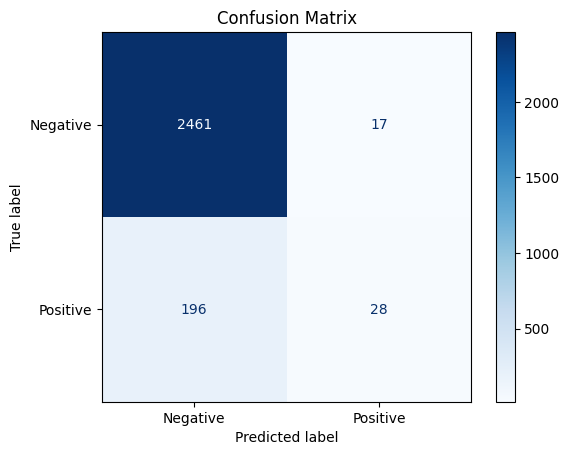

In [80]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/LSTM/lstm_inbalanced_cm')

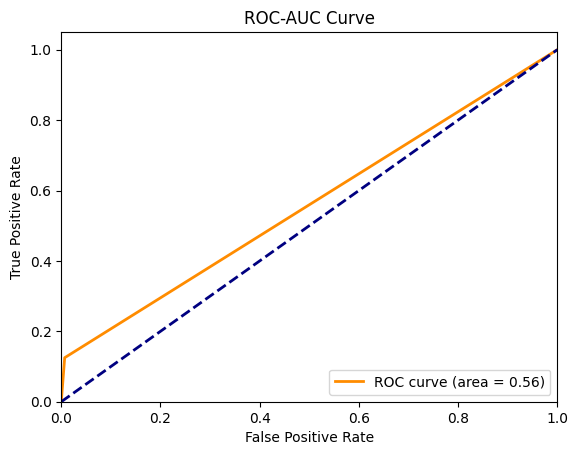

In [81]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/LSTM/lstm_inbalanced_roc_auc')

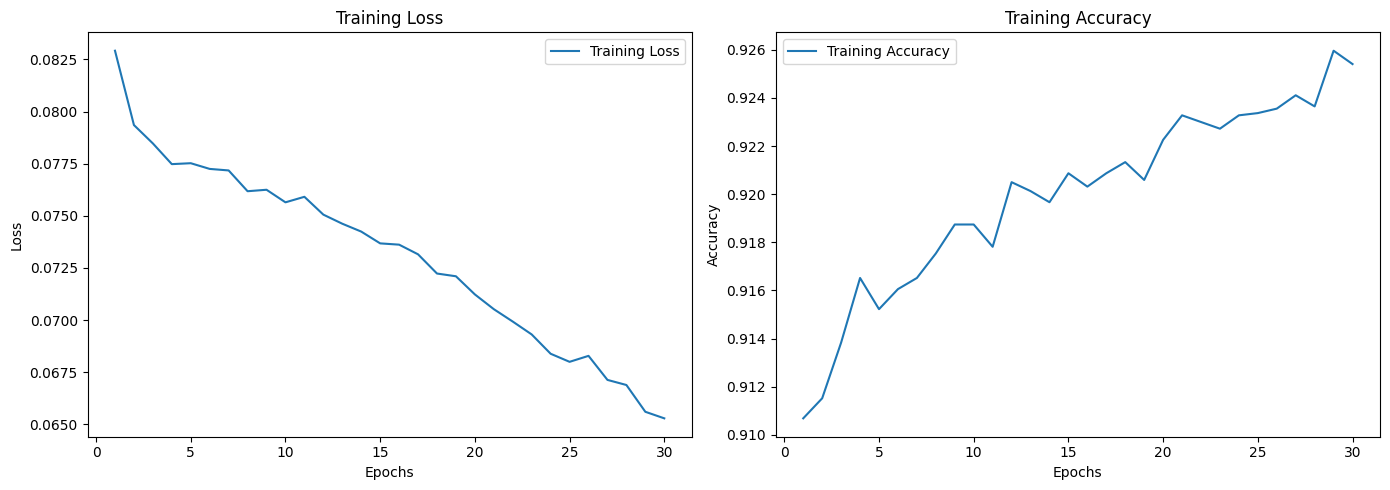

In [82]:
hf.plot_history(history, '1_pair/LSTM/lstm_inbalanced_history')

In [83]:
results_df.loc[len(results_df)] = ['1', 'LSTM', False, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df

,Tokenization,Model,Balanced,F1-score,Mean F1-score
0,1,LSTM,False,0.208178,0.583349


* Fit into balanced data

In [84]:
LSTM_model_1 = Model(inputs=inputs, outputs=outputs)
LSTM_model_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                     loss='binary_focal_crossentropy',
                     metrics=['accuracy'])

In [85]:
history = LSTM_model_1.fit(sequences_1p_train_balanced, labels_1p_train_balanced, epochs=30, batch_size=25)

Epoch 1/30
78/78 [==============================] - 11s 117ms/step - loss: 0.1463 - accuracy: 0.6829
Epoch 2/30
78/78 [==============================] - 8s 106ms/step - loss: 0.1311 - accuracy: 0.7155
Epoch 3/30
78/78 [==============================] - 7s 87ms/step - loss: 0.1286 - accuracy: 0.7259
Epoch 4/30
78/78 [==============================] - 8s 100ms/step - loss: 0.1237 - accuracy: 0.7487
Epoch 5/30
78/78 [==============================] - 9s 116ms/step - loss: 0.1215 - accuracy: 0.7544
Epoch 6/30
78/78 [==============================] - 9s 111ms/step - loss: 0.1177 - accuracy: 0.7668
Epoch 7/30
78/78 [==============================] - 8s 108ms/step - loss: 0.1141 - accuracy: 0.7689
Epoch 8/30
78/78 [==============================] - 8s 97ms/step - loss: 0.1131 - accuracy: 0.7772
Epoch 9/30
78/78 [==============================] - 9s 115ms/step - loss: 0.1105 - accuracy: 0.7870
Epoch 10/30
78/78 [==============================] - 8s 101ms/step - loss: 0.1071 - accuracy: 0.8062


In [86]:
predictions = LSTM_model_1.predict(sequences_1p_test)

85/85 [==============================] - 6s 63ms/step


In [87]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.6154700222057735
Mean F1 Score:  0.4649877127635753
F1 Score:  0.18124507486209615
Loss:  0.75


In [88]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.62      0.75      2478
    Positive       0.11      0.51      0.18       224

    accuracy                           0.62      2702
   macro avg       0.52      0.57      0.46      2702
weighted avg       0.87      0.62      0.70      2702



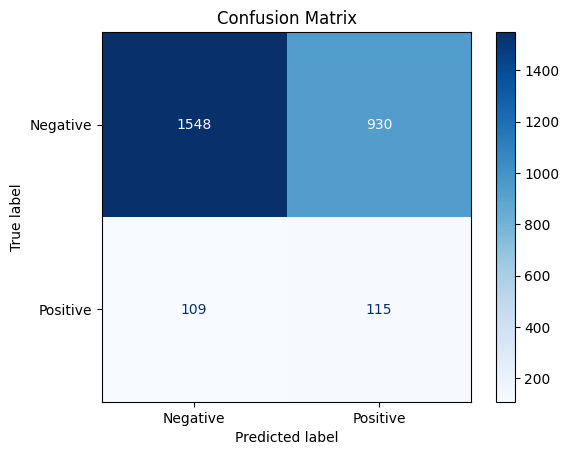

In [89]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/LSTM/lstm_balanced_cm')

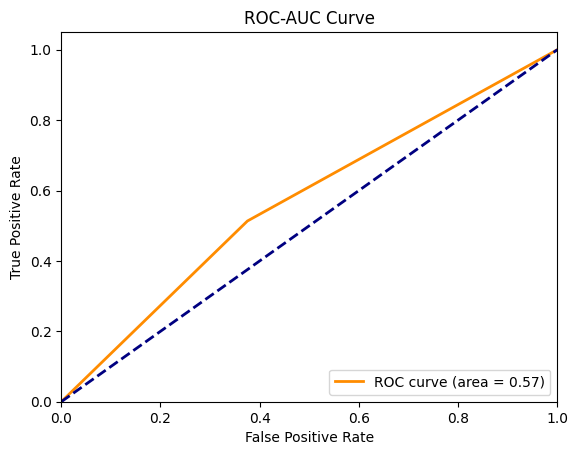

In [90]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/LSTM/lstm_balanced_roc_auc')

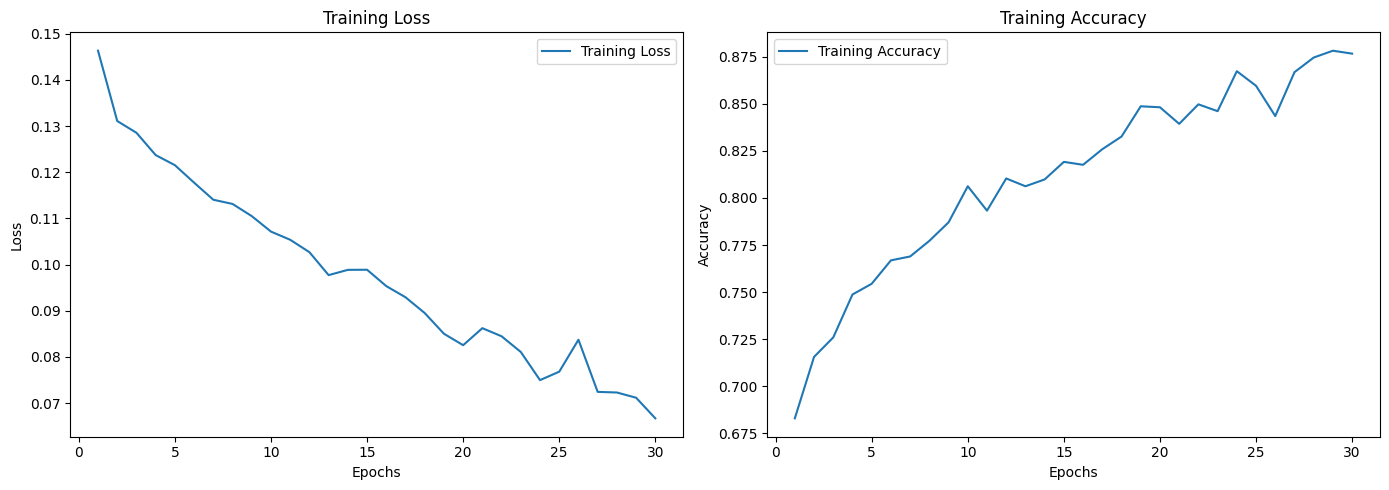

In [91]:
hf.plot_history(history, '1_pair/LSTM/lstm_balanced_history')

In [92]:
results_df.loc[len(results_df)] = ['1', 'LSTM', True, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df

,Tokenization,Model,Balanced,F1-score,Mean F1-score
0,1,LSTM,False,0.208178,0.583349
1,1,LSTM,True,0.181245,0.464988


### Transformer

In [93]:
# input_layer = Input(shape=(sequence_len), name='Input')


# x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
# x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)


# for i in range(2):
#     attention = MultiHeadAttention(num_heads=4, key_dim=embedding_dim, name=f'Attention_{i}')(x, x) 
#     attention = Dropout(0.1, name=f'Dropout1_b{i}')(attention)

#     attention = tf.cast(attention, dtype=tf.float16)
#     x = tf.cast(x, dtype=tf.float16) 
    
#     x = LayerNormalization(epsilon=1e-6, name=f'LayerNorm1_{i}')(x + attention)
    
#     dense = Dense(embedding_dim, activation='relu', name=f'Dense1_b{i}')(x)
#     dense = Dense(embedding_dim, activation='relu', name=f'Dense2_{i}')(dense)
    
#     dense = Dropout(0.1, name=f'Dropout2_b{i}')(dense)
    
#     x = LayerNormalization(epsilon=1e-6, name=f'LayerNorm2_{i}')(x + dense)


# x = GlobalAveragePooling1D(name='GAPooling1D')(x)
# x = Dropout(0.1, name='Dropout')(x)

# outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

* Model Initialisation

In [98]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')


x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation=tf.keras.activations.sigmoid, name='Output')(x)

In [99]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                      loss='binary_focal_crossentropy',
                      metrics=['accuracy'])

In [100]:
transformer_1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 1021)]               0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 1021, 500)            11500     ['Input[0][0]']               
                                                                                                  
 positional_encoding_1 (Pos  (None, 1021, 500)            0         ['Embeddings[0][0]']          
 itionalEncoding)                                                                                 
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 1021, 500)            1001550   ['positional_encoding_1[

* Fit into inbalanced data

In [101]:
history = transformer_1.fit(sequences_1p_train, labels_1p_train, epochs=30, batch_size=25)

Epoch 1/30
433/433 [==============================] - 139s 316ms/step - loss: 0.1812 - accuracy: 0.9011
Epoch 2/30
433/433 [==============================] - 148s 343ms/step - loss: 0.0879 - accuracy: 0.9106
Epoch 3/30
433/433 [==============================] - 148s 343ms/step - loss: 0.0843 - accuracy: 0.9106
Epoch 4/30
433/433 [==============================] - 147s 339ms/step - loss: 0.0826 - accuracy: 0.9105
Epoch 5/30
433/433 [==============================] - 148s 341ms/step - loss: 0.0811 - accuracy: 0.9107
Epoch 6/30
433/433 [==============================] - 150s 347ms/step - loss: 0.0808 - accuracy: 0.9113
Epoch 7/30
433/433 [==============================] - 147s 340ms/step - loss: 0.0802 - accuracy: 0.9121
Epoch 8/30
433/433 [==============================] - 149s 344ms/step - loss: 0.0786 - accuracy: 0.9143
Epoch 9/30
433/433 [==============================] - 149s 344ms/step - loss: 0.0782 - accuracy: 0.9146
Epoch 10/30
433/433 [==============================] - 148s 343m

In [106]:
predictions = transformer_1.predict(sequences_1p_test)

85/85 [==============================] - 12s 133ms/step


In [107]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.9226498889711325
Mean F1 Score:  0.5940326790760602
F1 Score:  0.22878228782287824
Loss:  0.414


In [108]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96      2478
    Positive       0.66      0.14      0.23       224

    accuracy                           0.92      2702
   macro avg       0.79      0.57      0.59      2702
weighted avg       0.91      0.92      0.90      2702



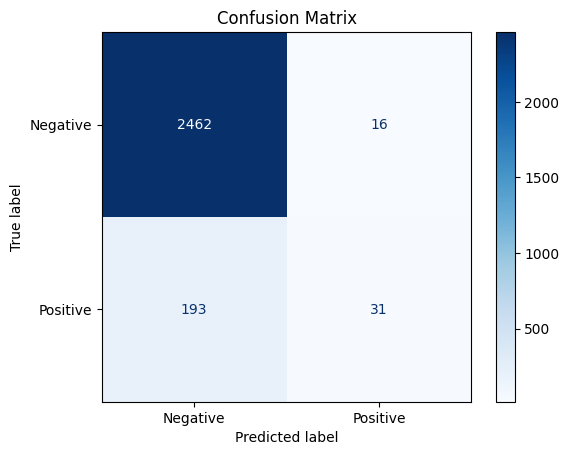

In [109]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/Transformer/transformer_inbalanced_cm')

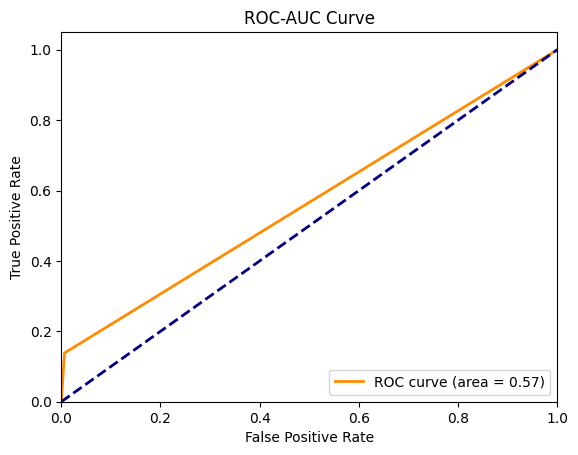

In [110]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/Transformer/transformer_inbalanced_roc_auc')

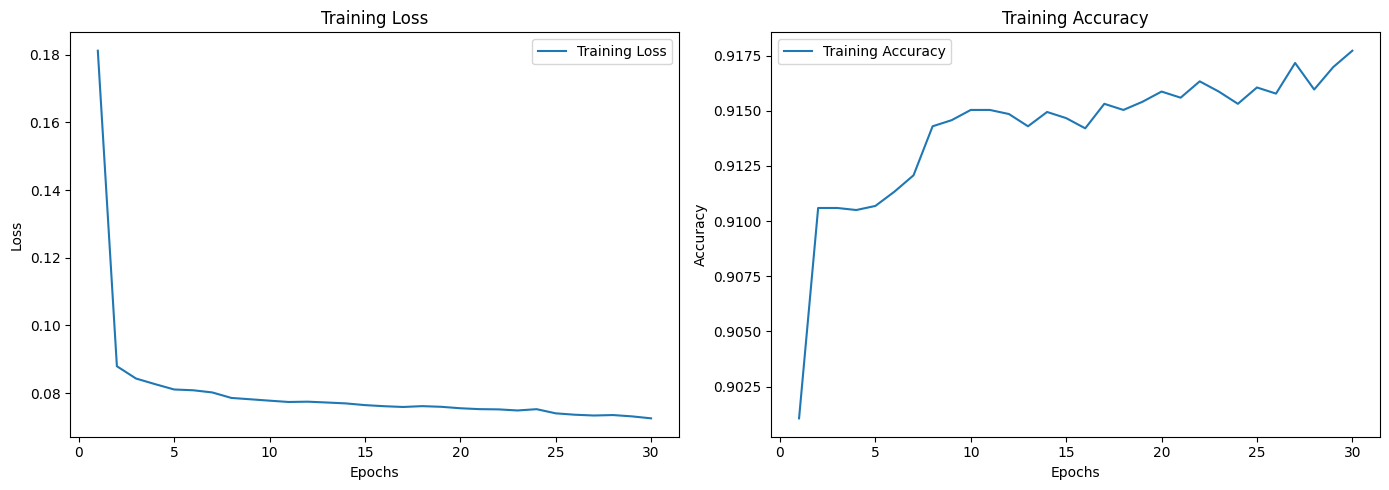

In [111]:
hf.plot_history(history, '1_pair/Transformer/transformer_inbalanced_history')

In [112]:
results_df.loc[len(results_df)] = ['1', 'Transformer', False, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df

,Tokenization,Model,Balanced,F1-score,Mean F1-score
0,1,LSTM,False,0.208178,0.583349
1,1,LSTM,True,0.181245,0.464988
2,1,Transformer,False,0.228782,0.594033


* Fit into balanced data

In [113]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                      loss='binary_focal_crossentropy',
                      metrics=['accuracy'])

In [114]:
history = transformer_1.fit(sequences_1p_train_balanced, labels_1p_train_balanced, epochs=30, batch_size=25)

Epoch 1/30
78/78 [==============================] - 25s 290ms/step - loss: 0.1578 - accuracy: 0.6440
Epoch 2/30
78/78 [==============================] - 22s 278ms/step - loss: 0.1495 - accuracy: 0.6803
Epoch 3/30
78/78 [==============================] - 22s 278ms/step - loss: 0.1485 - accuracy: 0.6679
Epoch 4/30
78/78 [==============================] - 22s 281ms/step - loss: 0.1471 - accuracy: 0.6829
Epoch 5/30
78/78 [==============================] - 22s 278ms/step - loss: 0.1457 - accuracy: 0.6943
Epoch 6/30
78/78 [==============================] - 22s 278ms/step - loss: 0.1430 - accuracy: 0.6964
Epoch 7/30
78/78 [==============================] - 22s 278ms/step - loss: 0.1436 - accuracy: 0.6964
Epoch 8/30
78/78 [==============================] - 22s 280ms/step - loss: 0.1429 - accuracy: 0.7016
Epoch 9/30
78/78 [==============================] - 22s 278ms/step - loss: 0.1413 - accuracy: 0.7062
Epoch 10/30
78/78 [==============================] - 22s 278ms/step - loss: 0.1369 - accura

In [115]:
predictions = transformer_1.predict(sequences_1p_test)

85/85 [==============================] - 11s 130ms/step


In [116]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.7524056254626202
Mean F1 Score:  0.5343543011172326
F1 Score:  0.21570926143024619
Loss:  0.6143


In [117]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.94      0.78      0.85      2478
    Positive       0.15      0.41      0.22       224

    accuracy                           0.75      2702
   macro avg       0.54      0.60      0.53      2702
weighted avg       0.87      0.75      0.80      2702



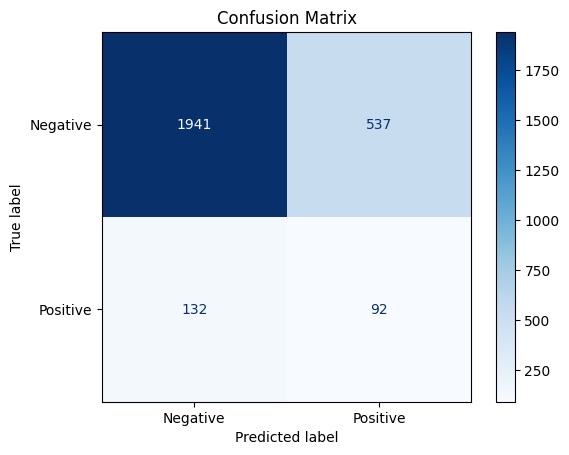

In [118]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/Transformer/transformer_balanced_cm')

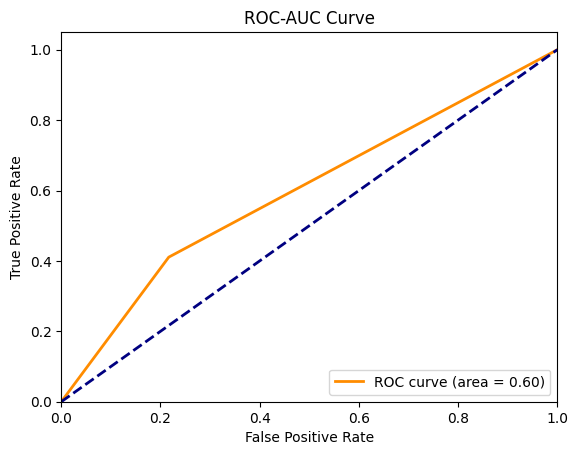

In [119]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/Transformer/transformer_balanced_roc_auc')

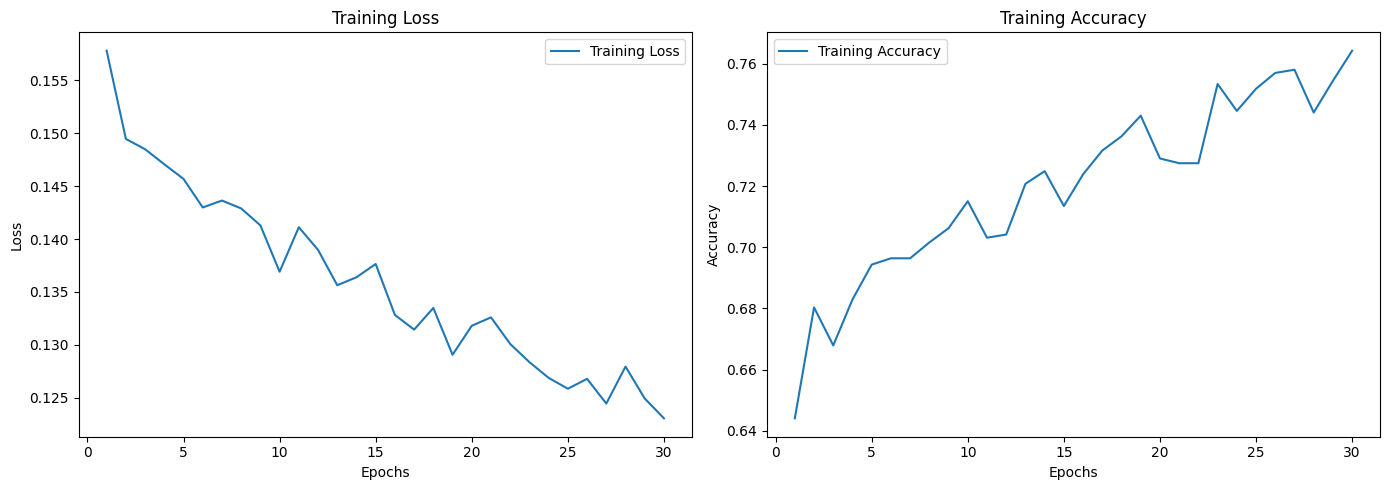

In [120]:
hf.plot_history(history, '1_pair/Transformer/transformer_balanced_history')

In [121]:
results_df.loc[len(results_df)] = ['1', 'Transformer', True, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df

,Tokenization,Model,Balanced,F1-score,Mean F1-score
0,1,LSTM,False,0.208178,0.583349
1,1,LSTM,True,0.181245,0.464988
2,1,Transformer,False,0.228782,0.594033
3,1,Transformer,True,0.215709,0.534354


### CNN Transformer

* Model Initialisation

In [133]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')
input_layer = Reshape((sequence_len, 1))(input_layer)

cnn1 = Conv1D(filters=embedding_dim, kernel_size=6, padding='same', activation='relu', name='Conv1D_1')(input_layer)
max_pool1 = MaxPooling1D(pool_size=2, name='MaxPooling1D_1')(cnn1)
# cnn2 = Conv1D(filters=embedding_dim, kernel_size=6, padding='same', activation='relu', name='Conv1D_2')(max_pool1)
# max_pool2 = MaxPooling1D(pool_size=2, name='MaxPooling1D_2')(cnn2)

x = PositionalEncoding(position=sequence_len // 2, d_model=embedding_dim)(max_pool1)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention_1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense_1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense_2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [134]:
cnn_transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
cnn_transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                          loss="binary_focal_crossentropy",
                          metrics=['accuracy'])

In [135]:
cnn_transformer_1.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1021, 1)]            0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 1021, 500)            3500      ['input_2[0][0]']             
                                                                                                  
 MaxPooling1D_1 (MaxPooling  (None, 510, 500)             0         ['Conv1D_1[1][0]']            
 1D)                                                                                              
                                                                                                  
 positional_encoding_3 (Pos  (None, 510, 500)             0         ['MaxPooling1D_1[1][0]']

* Fit into inbalanced data

In [136]:
history = cnn_transformer_1.fit(sequences_1p_train, labels_1p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 52s 148ms/step - loss: 0.1389 - accuracy: 0.9000
Epoch 2/30
338/338 [==============================] - 49s 146ms/step - loss: nan - accuracy: 0.9107
Epoch 3/30
338/338 [==============================] - 50s 147ms/step - loss: nan - accuracy: 0.9105
Epoch 4/30
338/338 [==============================] - 50s 147ms/step - loss: nan - accuracy: 0.9106
Epoch 5/30
338/338 [==============================] - 50s 147ms/step - loss: nan - accuracy: 0.9105
Epoch 6/30
338/338 [==============================] - 50s 149ms/step - loss: nan - accuracy: 0.9104
Epoch 7/30
338/338 [==============================] - 50s 149ms/step - loss: nan - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 50s 148ms/step - loss: nan - accuracy: 0.9097
Epoch 9/30
338/338 [==============================] - 49s 146ms/step - loss: nan - accuracy: 0.9107
Epoch 10/30
338/338 [==============================] - 49s 146ms/step - loss: nan - accuracy: 0.9

In [137]:
predictions = cnn_transformer_1.predict(sequences_1p_test)

85/85 [==============================] - 5s 54ms/step


In [138]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.917098445595855
Mean F1 Score:  0.4783783783783784
F1 Score:  0.0
Loss:  nan


In [139]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



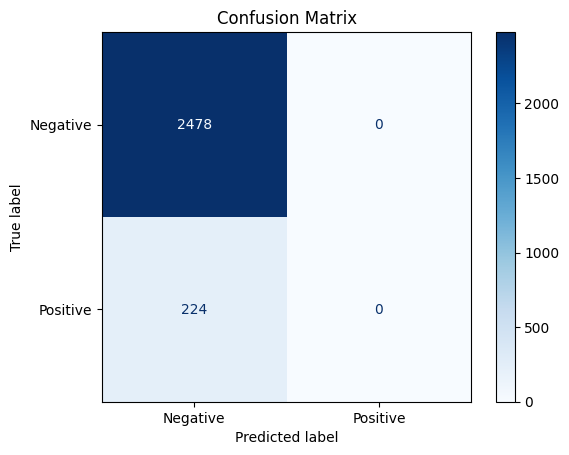

In [140]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/CNN_Transformer/cnn_transformer_inbalanced_cm')

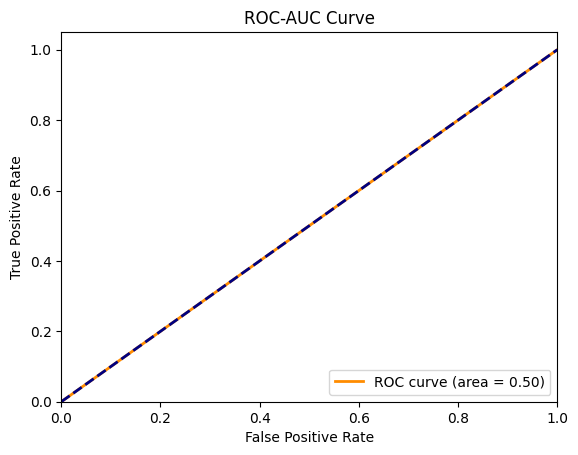

In [141]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/CNN_Transformer/cnn_transformer_inbalanced_roc_auc')

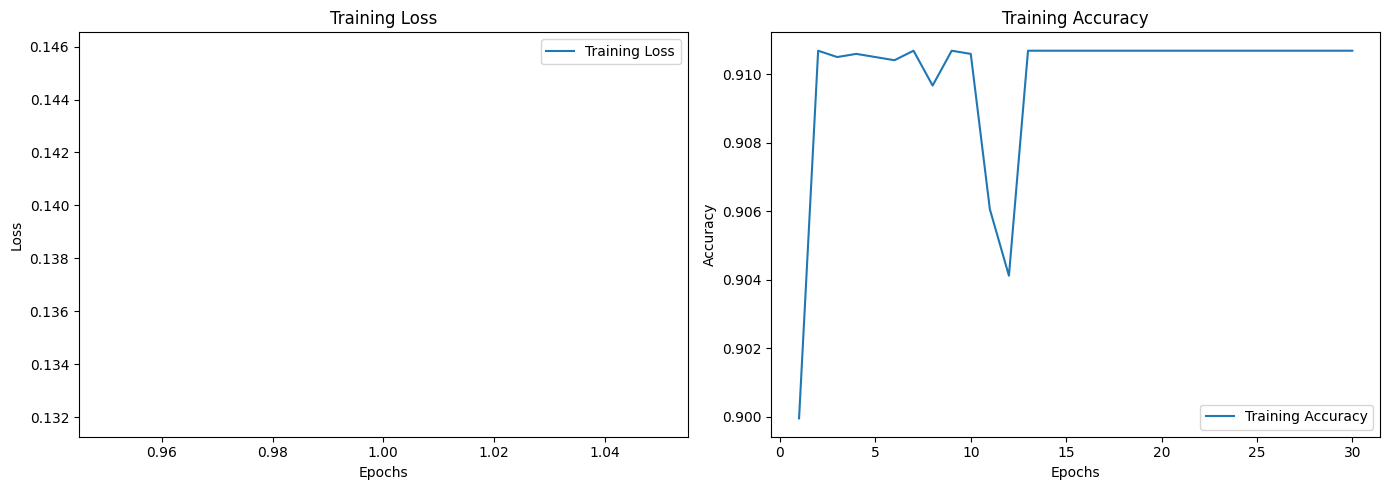

In [142]:
hf.plot_history(history, '1_pair/CNN_Transformer/cnn_transformer_inbalanced_history')

In [143]:
results_df.loc[len(results_df)] = ['1', 'CNN_Transformer', False, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df

,Tokenization,Model,Balanced,F1-score,Mean F1-score
0,1,LSTM,False,0.208178,0.583349
1,1,LSTM,True,0.181245,0.464988
2,1,Transformer,False,0.228782,0.594033
3,1,Transformer,True,0.215709,0.534354
4,1,CNN_Transformer,False,0.000000,0.478378
5,1,CNN_Transformer,False,0.000000,0.478378


* Fit into balanced data

### Results

In [145]:
results_df

,Tokenization,Model,Balanced,F1-score,Mean F1-score
0,1,LSTM,False,0.208178,0.583349
1,1,LSTM,True,0.181245,0.464988
2,1,Transformer,False,0.228782,0.594033
3,1,Transformer,True,0.215709,0.534354
4,1,CNN_Transformer,False,0.000000,0.478378


## Modeling (2 Aminos Tokenization)

In [164]:
sequence_len = sequences_2p_train.shape[1]
voc_size = len(tokenizer2.word_index)
embedding_dim = 500

voc_size

466

### LSTM

In [61]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [62]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1014)]            0         
                                                                 
 Embeddings (Embedding)      (None, 1014, 400)         186400    
                                                                 
 LSTM_layer_1 (LSTM)         (None, 1014, 20)          33680     
                                                                 
 dropout_3 (Dropout)         (None, 1014, 20)          0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55  

In [63]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_focal_crossentropy, metrics=['accuracy'])

In [64]:
history = model_1.fit(sequences_2p_train, labels_2p_train, epochs=2, batch_size=25)

Epoch 1/2
454/454 [==============================] - 47s 100ms/step - loss: 0.0835 - accuracy: 0.9098
Epoch 2/2
454/454 [==============================] - 46s 102ms/step - loss: 0.0828 - accuracy: 0.9098


In [65]:
predictions = model_1.predict(sequences_2p_test)

89/89 [==============================] - 5s 50ms/step


In [66]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.4338


In [67]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



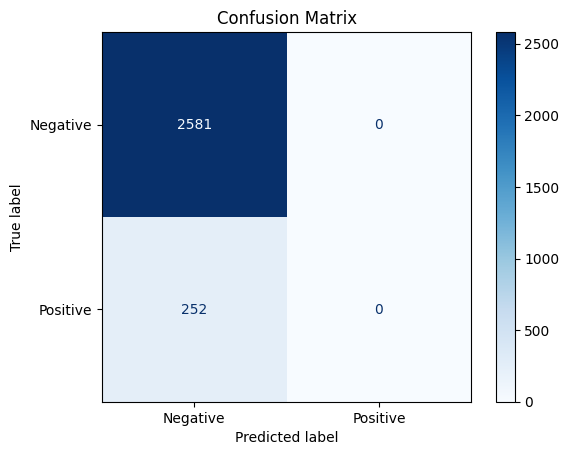

In [68]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/2p_lstm_baseline_cm')

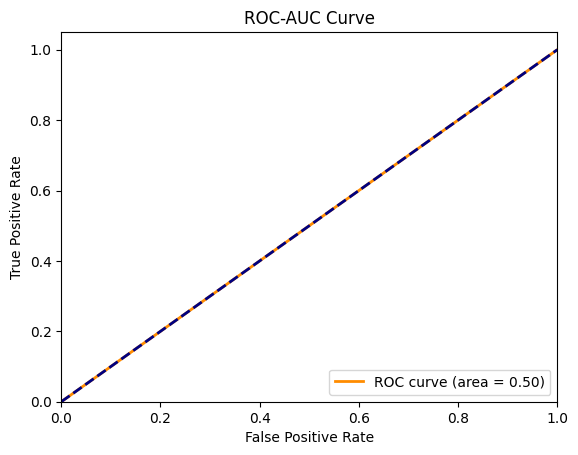

In [69]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/2p_lstm_baseline_roc_auc')

### Transformer

In [105]:
# input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

# x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

# x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

# for i in range(4):
#     x = hf.transformer_block(x, 3, embedding_dim, i)

# x = GlobalAveragePooling1D(name='GAPooling1D')(x)
# x = Dropout(0.1, name='Dropout2')(x)

# outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [167]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')


x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention1')(x, x)
attention = Dropout(0.1, name='Dropout1')(attention)

attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout2')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [168]:
transformer_2 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_2.compile(optimizer=tf.keras.optimizers.AdamW(), loss=tf.keras.losses.binary_focal_crossentropy, metrics=["accuracy"])

In [169]:
transformer_2.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 499)]                0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 499, 500)             233000    ['Input[0][0]']               
                                                                                                  
 positional_encoding_11 (Po  (None, 499, 500)             0         ['Embeddings[0][0]']          
 sitionalEncoding)                                                                                
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 499, 500)             1001550   ['positional_encoding_1

In [177]:
history = transformer_2.fit(sequences_2p_train, labels_2p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 56s 163ms/step - loss: 0.0834 - accuracy: 0.9090
Epoch 2/30
338/338 [==============================] - 53s 158ms/step - loss: 0.0818 - accuracy: 0.9107
Epoch 3/30
338/338 [==============================] - 54s 161ms/step - loss: 0.0814 - accuracy: 0.9107
Epoch 4/30
338/338 [==============================] - 55s 163ms/step - loss: 0.0815 - accuracy: 0.9107
Epoch 5/30
338/338 [==============================] - 54s 159ms/step - loss: 0.0809 - accuracy: 0.9107
Epoch 6/30
338/338 [==============================] - 55s 162ms/step - loss: 0.0804 - accuracy: 0.9107
Epoch 7/30
338/338 [==============================] - 55s 163ms/step - loss: 0.0799 - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 55s 163ms/step - loss: 0.0797 - accuracy: 0.9107
Epoch 9/30
338/338 [==============================] - 52s 155ms/step - loss: 0.0800 - accuracy: 0.9106
Epoch 10/30
338/338 [==============================] - 50s 149ms/step - l

In [178]:
predictions = transformer_2.predict(sequences_2p_test)

85/85 [==============================] - 5s 53ms/step


In [179]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.917098445595855
Loss:  0.3782


In [180]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



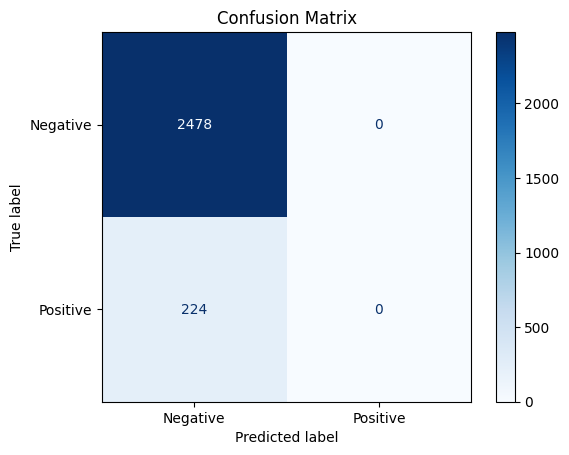

In [181]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/2p_transformer_1_cm')

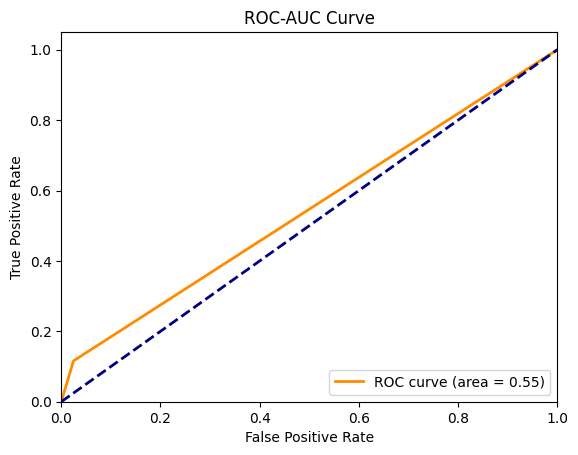

In [175]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/2p_transformer_1_roc_auc')

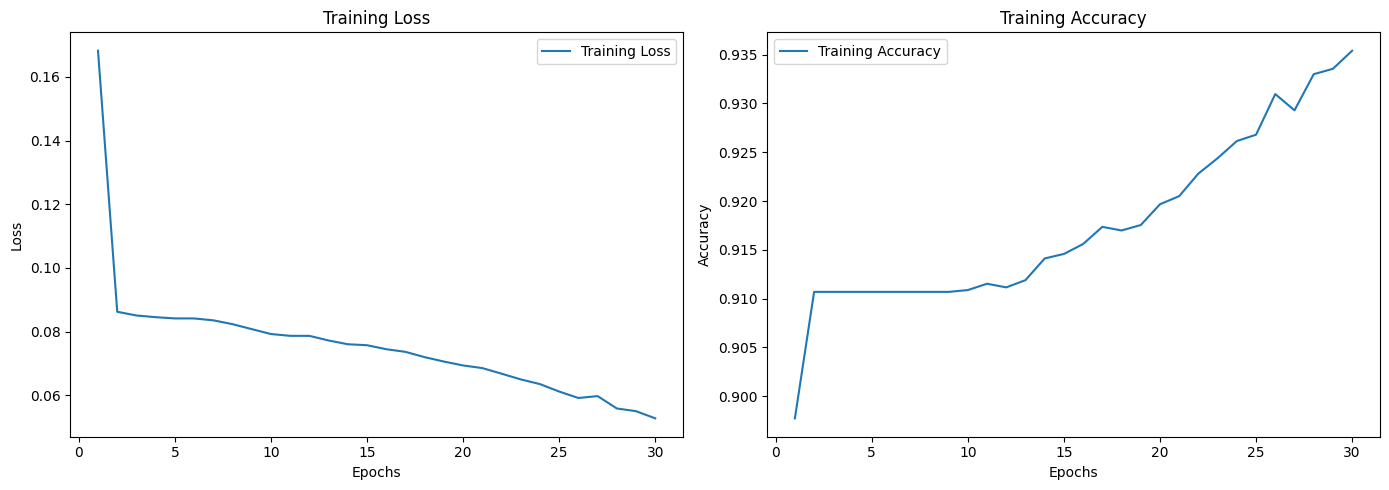

In [176]:
hf.plot_history(history)

## Modeling (3 Aminos Tokenization)

In [159]:
sequence_len = sequences_3p_train.shape[1]
voc_size = len(tokenizer3.word_index)
embedding_dim = 400

voc_size

8476

### LSTM

In [81]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [82]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 676)]             0         
                                                                 
 Embeddings (Embedding)      (None, 676, 400)          3390800   
                                                                 
 LSTM_layer_1 (LSTM)         (None, 676, 20)           33680     
                                                                 
 dropout_5 (Dropout)         (None, 676, 20)           0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55  

In [90]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_focal_crossentropy, metrics=['accuracy'])

In [91]:
history = model_1.fit(sequences_3p_train, labels_3p_train, epochs=8, batch_size=25)

Epoch 1/8
454/454 [==============================] - 66s 143ms/step - loss: 0.0840 - accuracy: 0.9098
Epoch 2/8
454/454 [==============================] - 51s 111ms/step - loss: 0.0828 - accuracy: 0.9098
Epoch 3/8
454/454 [==============================] - 44s 96ms/step - loss: 0.0826 - accuracy: 0.9098
Epoch 4/8
454/454 [==============================] - 41s 91ms/step - loss: 0.0827 - accuracy: 0.9098
Epoch 5/8
454/454 [==============================] - 36s 80ms/step - loss: 0.0827 - accuracy: 0.9098
Epoch 6/8
454/454 [==============================] - 39s 85ms/step - loss: 0.0825 - accuracy: 0.9098
Epoch 7/8
454/454 [==============================] - 36s 80ms/step - loss: 0.0825 - accuracy: 0.9098
Epoch 8/8
454/454 [==============================] - 34s 75ms/step - loss: 0.0827 - accuracy: 0.9098


In [93]:
predictions = model_1.predict(sequences_3p_test)

89/89 [==============================] - 3s 29ms/step


In [94]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.4358


In [95]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



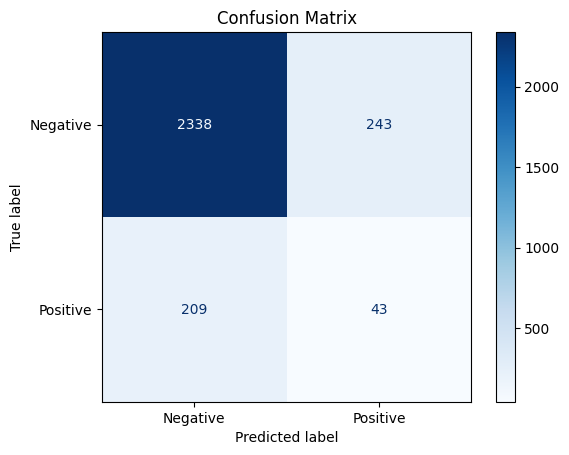

In [58]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/3p_lstm_baseline_cm')

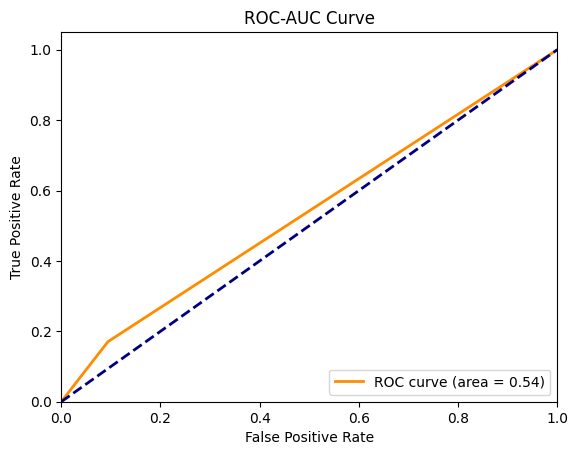

In [59]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/3p_lstm_baseline_roc_auc')

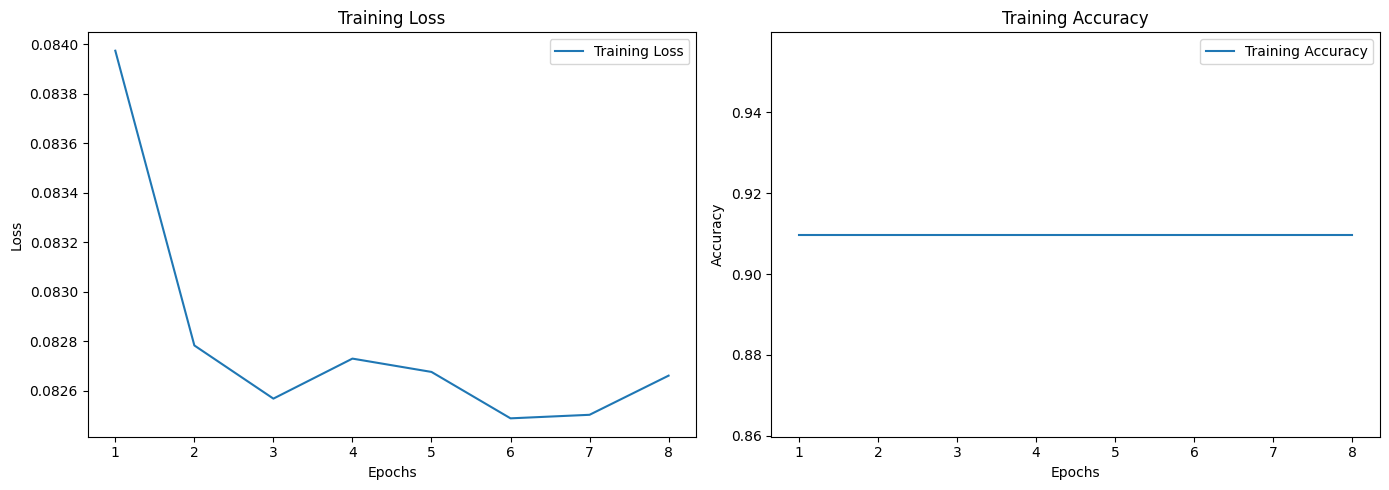

In [98]:
hf.plot_history(history)

### Transformer

In [181]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

attention = MultiHeadAttention(num_heads=2, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)

x = GlobalAveragePooling1D(name='GAPooling1D')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [182]:
transformer_3 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_3.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [183]:
transformer_3.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 333)]                0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 333, 400)             3390400   ['Input[0][0]']               
                                                                                                  
 positional_encoding_18 (Po  (None, 333, 400)             0         ['Embeddings[0][0]']          
 sitionalEncoding)                                                                                
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 333, 400)             1282800   ['positional_encoding_1

In [184]:
history = transformer_3.fit(sequences_3p_train, labels_3p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 25s 69ms/step - loss: 0.3122 - accuracy: 0.9107
Epoch 2/30
338/338 [==============================] - 18s 53ms/step - loss: 0.3036 - accuracy: 0.9107
Epoch 3/30
338/338 [==============================] - 15s 46ms/step - loss: 0.3049 - accuracy: 0.9107
Epoch 4/30
338/338 [==============================] - 15s 45ms/step - loss: 0.3036 - accuracy: 0.9107
Epoch 5/30
338/338 [==============================] - 14s 41ms/step - loss: 0.3032 - accuracy: 0.9107
Epoch 6/30
338/338 [==============================] - 13s 39ms/step - loss: 0.3031 - accuracy: 0.9107
Epoch 7/30
338/338 [==============================] - 13s 37ms/step - loss: 0.3028 - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 12s 37ms/step - loss: 0.3084 - accuracy: 0.9107
Epoch 9/30
338/338 [==============================] - 13s 37ms/step - loss: 0.3072 - accuracy: 0.9107
Epoch 10/30
338/338 [==============================] - 12s 37ms/step - loss: 0.304

In [187]:
predictions = transformer_3.predict(sequences_3p_test)

85/85 [==============================] - 1s 11ms/step


In [188]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.8612139156180607
Loss:  0.702


In [189]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      2478
    Positive       0.17      0.18      0.18       224

    accuracy                           0.86      2702
   macro avg       0.55      0.55      0.55      2702
weighted avg       0.86      0.86      0.86      2702



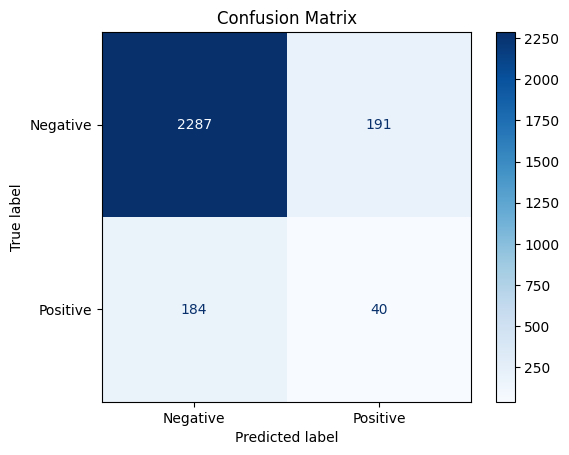

In [190]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/3p_transformer_1_cm')

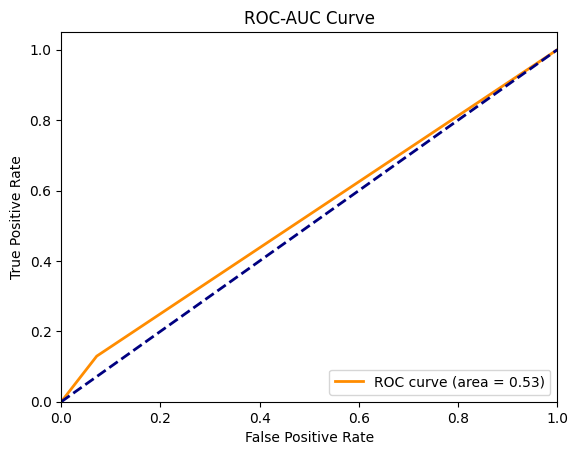

In [179]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/3p_transformer_1_roc_auc')

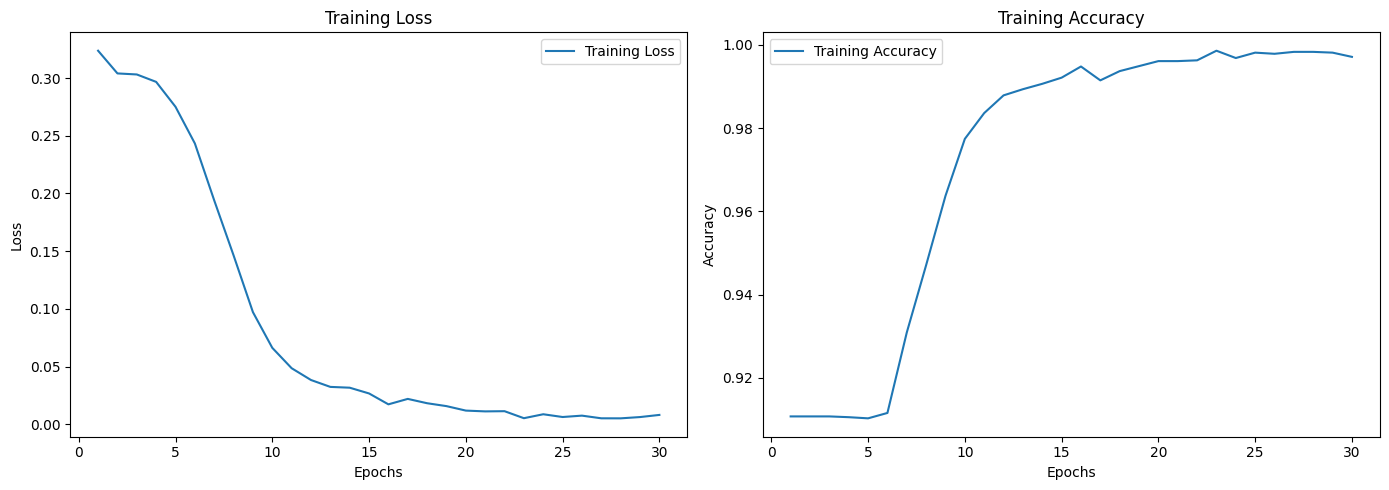

In [180]:
hf.plot_history(history)